<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

print("done all")

In [ ]:
nltk.download('punkt')

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

In [ ]:
from nltk import tokenize

print("done all")

In [ ]:
print(dataset)

In [ ]:
# посмотрим, что там есть
unique_labels = set([example['label'] for example in dataset['train']])
print(unique_labels)


In [ ]:
# сколько каких категорий
number_of_negatives = sum(1 for example in dataset['train'] if example['label'] == 0)
print(number_of_negatives)
number_of_positives = sum(1 for example in dataset['train'] if example['label'] == 1)
print(number_of_positives)
total_number = len(dataset['train'])
print(total_number)


In [ ]:
# пару примеров
i = 0
for example in dataset['train']:
    if i <= 1:
        print(example['text'])
        print(example['label'])
    i +=1

    

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
import re

sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences

for text in tqdm(dataset['train']['text']):
    for sentence in sent_tokenize(text, language='english'): 
        words = re.findall(r'\w+', sentence) # может можно и лучше побить по словам
        if len(words) <= word_threshold:
            sentences.append(sentence)


In [ ]:
# посмотрим, какая макс длина в словах получилась, и какое там предложение
max_length = max(len(sentence.split()) for sentence in sentences)
print(max_length)

for sentence in sentences:
    if len(sentence.split()) == max_length:
        print(sentence)
        



In [ ]:
# посмотрим распределение по длинам предложений

import matplotlib.pyplot as plt
import numpy as np


# Для демонстрации создадим массив случайных длин предложений
np.random.seed(0) # Для воспроизводимости результатов
sentence_lengths = []
for sentence in sentences:
    sentence_lengths.append(len(sentence.split()))

# Построение гистограммы длин предложений
plt.figure(figsize=(12, 8))

# Для большого количества данных лучше использовать больше корзин для гистограммы
# или позволить matplotlib автоматически определить оптимальное их количество.
# Автоматическое определение количества корзин:
bin_edges = np.histogram_bin_edges(sentence_lengths, bins='auto')

plt.hist(sentence_lengths, bins=bin_edges, alpha=0.7, color='blue', edgecolor='black')

plt.title('Распределение длин предложений')
plt.xlabel('Длина предложения (количество слов)')
plt.ylabel('Количество предложений')

# Установим шаг для отметок на оси X для улучшения читаемости
tick_step = max(1, len(bin_edges) // 20) # Не более 20 отметок на оси X
plt.xticks(bin_edges[::tick_step])

plt.grid(True) # Добавляем сетку для лучшей ориентации
plt.tight_layout() # Автоматическая корректировка подписей, чтобы они не перекрывались

plt.show()


устраивает. Не буду бороться с тем, что   words = re.findall(r'\w+', sentence) оставляет + - и т.п.

In [ ]:
print("Всего предложений:", len(sentences))

Посчитаем для каждого слова его встречаемость.

In [15]:
words = Counter()

# Расчет встречаемости слов

for sentence in tqdm(sentences):
    tokenized_sentence = word_tokenize(sentence, language='english')
    for word in tokenized_sentence:
        words[word] += 1

In [16]:
len(words)

93181

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [17]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

most_common_words = words.most_common(vocab_size) # на любой чих тут встроенные методы -)

# Наполнение словаря
for word, _ in most_common_words:
    vocab.add(word)

In [18]:
len(vocab)

40004

In [19]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [20]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [21]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

print("ok")

ok


In [22]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)
    
print("ok")

ok


In [23]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [24]:
train_sentences, temp_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(temp_sentences, test_size=0.5)


train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 16 # это борьба с ООМ (OutOfMemoryError: CUDA out of memory. 
# Tried to allocate 3.74 GiB. GPU 0 has a total capacty of 14.75 GiB of which 2.96 GiB is free. 
# Process 3799 has 11.78 GiB memory in use. Of the allocated memory 11.57 GiB is allocated by PyTorch, 
# and 77.50 MiB is reserved by PyTorch but unallocated. 
# If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  
# See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [25]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

print('ok')

ok


### Train loop (1 балл)

Напишите функцию для обучения модели.

In [26]:
def train_model(model, epochs=10):
    # Напишите код здесь
    num_epoch = epochs
    losses = []
    perplexities = []

    for epoch in range(epochs):
        epoch_losses = []
        model.train()
        for batch in train_dataloader:  # Убрано оборачивание в tqdm
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        perplexity = evaluate(model, criterion, eval_dataloader)

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
    
    # Вывод средней потери и перплексии для отслеживания процесса обучения
        print(f"Epoch {epoch+1}: Average Loss = {avg_loss:.4f}, Perplexity = {perplexity:.4f}")

    return losses, perplexities
    
print('ok')
    


ok


### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [27]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]    
    
        return projection

In [28]:
model = LanguageModel(hidden_dim=64, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [29]:
# Обучите модель здесь
train_model(model, epochs=20)

Epoch 1: Average Loss = 2.0421, Perplexity = 5.5680
Epoch 2: Average Loss = 1.7257, Perplexity = 5.2489
Epoch 3: Average Loss = 1.6853, Perplexity = 5.0841
Epoch 4: Average Loss = 1.6598, Perplexity = 4.9818
Epoch 5: Average Loss = 1.6448, Perplexity = 4.9261
Epoch 6: Average Loss = 1.6346, Perplexity = 4.8805
Epoch 7: Average Loss = 1.6271, Perplexity = 4.8476
Epoch 8: Average Loss = 1.6218, Perplexity = 4.8302
Epoch 9: Average Loss = 1.6172, Perplexity = 4.8019
Epoch 10: Average Loss = 1.6133, Perplexity = 4.7910
Epoch 11: Average Loss = 1.6100, Perplexity = 4.7756
Epoch 12: Average Loss = 1.6071, Perplexity = 4.7599
Epoch 13: Average Loss = 1.6049, Perplexity = 4.7501
Epoch 14: Average Loss = 1.6025, Perplexity = 4.7445
Epoch 15: Average Loss = 1.6008, Perplexity = 4.7296
Epoch 16: Average Loss = 1.5991, Perplexity = 4.7225
Epoch 17: Average Loss = 1.5975, Perplexity = 4.7196
Epoch 18: Average Loss = 1.5962, Perplexity = 4.7168
Epoch 19: Average Loss = 1.5949, Perplexity = 4.7071
Ep

([2.042056216248713,
  1.7256567449154872,
  1.6853299366716874,
  1.6597712735461858,
  1.6448345134211744,
  1.634553178489893,
  1.6271377441962662,
  1.6217554211181684,
  1.617236777876451,
  1.6132890993109938,
  1.6100087548376283,
  1.6071335590714066,
  1.6048621702602957,
  1.6025439533421142,
  1.6008301820173199,
  1.5990566271359785,
  1.5974996395622447,
  1.5962423899302882,
  1.5949302035245108,
  1.593464809276752],
 [5.568030010949601,
  5.24890804221211,
  5.0841043355428415,
  4.9817957147727645,
  4.926112066995133,
  4.8804628057778965,
  4.847625499915938,
  4.830150500776818,
  4.8019227849402455,
  4.790965985938809,
  4.775593083762149,
  4.75994283365212,
  4.750129451723885,
  4.7444859650081135,
  4.729620515821973,
  4.722511050998513,
  4.7196428880128085,
  4.716838066113595,
  4.7070844684701,
  4.698919761972128])

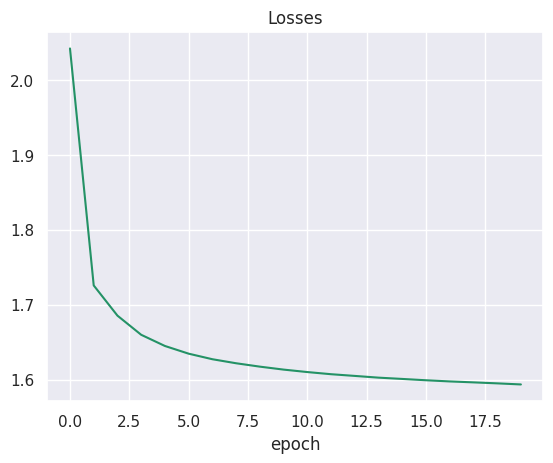

In [32]:
losses = [2.042056216248713,
  1.7256567449154872,
  1.6853299366716874,
  1.6597712735461858,
  1.6448345134211744,
  1.634553178489893,
  1.6271377441962662,
  1.6217554211181684,
  1.617236777876451,
  1.6132890993109938,
  1.6100087548376283,
  1.6071335590714066,
  1.6048621702602957,
  1.6025439533421142,
  1.6008301820173199,
  1.5990566271359785,
  1.5974996395622447,
  1.5962423899302882,
  1.5949302035245108,
  1.593464809276752]
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

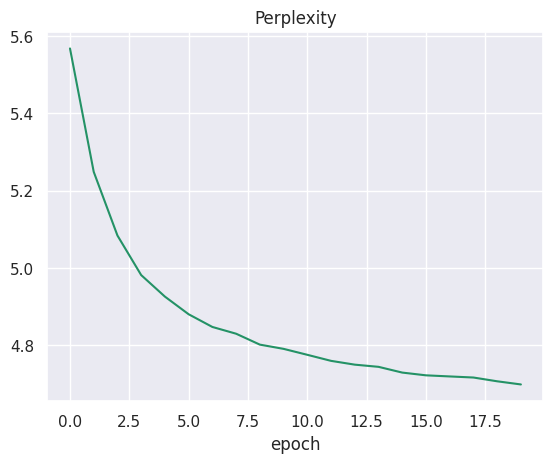

In [33]:
perplexities = [5.568030010949601,
  5.24890804221211,
  5.0841043355428415,
  4.9817957147727645,
  4.926112066995133,
  4.8804628057778965,
  4.847625499915938,
  4.830150500776818,
  4.8019227849402455,
  4.790965985938809,
  4.775593083762149,
  4.75994283365212,
  4.750129451723885,
  4.7444859650081135,
  4.729620515821973,
  4.722511050998513,
  4.7196428880128085,
  4.716838066113595,
  4.7070844684701,
  4.698919761972128]
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [35]:
evaluate(model, criterion, test_dataloader)

4.700847187153533

In [39]:
torch.save(model.state_dict(), 'model_state_LanguageModel.pth')


In [40]:
model = LanguageModel(hidden_dim=64, vocab_size=len(vocab))  # Параметры должны совпадать с теми, что были использованы при обучении

model.load_state_dict(torch.load('model_state_LanguageModel.pth'))
# model.eval()  # Переводим модель в режим оценки, если собираемся использовать для инференса


LanguageModel(
  (embedding): Embedding(40004, 64)
  (rnn): GRU(64, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=64, bias=True)
  (projection): Linear(in_features=64, out_features=40004, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.1, inplace=False)
)

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [42]:
# Проведите второй эксперимент
# Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm - хочу такое сделать


class LanguageModelLayerNorm(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)

        # Добавляем слой LayerNorm после RNN и после первого линейного слоя
        self.layer_norm_rnn = nn.LayerNorm(hidden_dim)
        self.layer_norm_linear = nn.LayerNorm(hidden_dim)

        self.projection = nn.Linear(hidden_dim, vocab_size)
        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.layer_norm_rnn(output)  # Применяем LayerNorm после RNN
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        output = self.layer_norm_linear(output)  # Применяем LayerNorm после первого линейного слоя
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]    
    
        return projection



In [43]:
model = LanguageModelLayerNorm(hidden_dim=64, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [44]:
train_model(model, epochs=20)

Epoch 1: Average Loss = 1.7914, Perplexity = 4.9302
Epoch 2: Average Loss = 1.6060, Perplexity = 4.7452
Epoch 3: Average Loss = 1.5805, Perplexity = 4.6658
Epoch 4: Average Loss = 1.5672, Perplexity = 4.6153
Epoch 5: Average Loss = 1.5588, Perplexity = 4.5868
Epoch 6: Average Loss = 1.5528, Perplexity = 4.5598
Epoch 7: Average Loss = 1.5479, Perplexity = 4.5401
Epoch 8: Average Loss = 1.5443, Perplexity = 4.5248
Epoch 9: Average Loss = 1.5413, Perplexity = 4.5123
Epoch 10: Average Loss = 1.5388, Perplexity = 4.5010
Epoch 11: Average Loss = 1.5367, Perplexity = 4.4967
Epoch 12: Average Loss = 1.5351, Perplexity = 4.4877
Epoch 13: Average Loss = 1.5334, Perplexity = 4.4867
Epoch 14: Average Loss = 1.5321, Perplexity = 4.4802
Epoch 15: Average Loss = 1.5309, Perplexity = 4.4691
Epoch 16: Average Loss = 1.5298, Perplexity = 4.4693
Epoch 17: Average Loss = 1.5287, Perplexity = 4.4632
Epoch 18: Average Loss = 1.5278, Perplexity = 4.4605
Epoch 19: Average Loss = 1.5270, Perplexity = 4.4549
Ep

([1.7914391741056024,
  1.6060213096577083,
  1.5805288581067185,
  1.567237405322143,
  1.558777547939272,
  1.5528194322956537,
  1.5479106631088535,
  1.5442518907786502,
  1.541332561931057,
  1.538801109749493,
  1.5366555613234771,
  1.535068685439258,
  1.5334266556694236,
  1.532070808725463,
  1.5308875509928597,
  1.5297533940947146,
  1.5286724905386777,
  1.5278089319661696,
  1.5270269839580577,
  1.5263614414513558],
 [4.93018712204447,
  4.745198629964972,
  4.665785683409999,
  4.615253045209388,
  4.5867587443601465,
  4.559820983115989,
  4.5400708238196845,
  4.524845527263561,
  4.512345005351205,
  4.500959762946087,
  4.496662636902278,
  4.487699613355529,
  4.486735775034242,
  4.480244586799894,
  4.469089148081105,
  4.469348334640069,
  4.46316024598025,
  4.460544991545396,
  4.454857790235357,
  4.452295632713646])

In [46]:
evaluate(model, criterion, test_dataloader)

4.4534978882228256

In [47]:
torch.save(model.state_dict(), 'model_state_LanguageModelLayerNorm.pth')


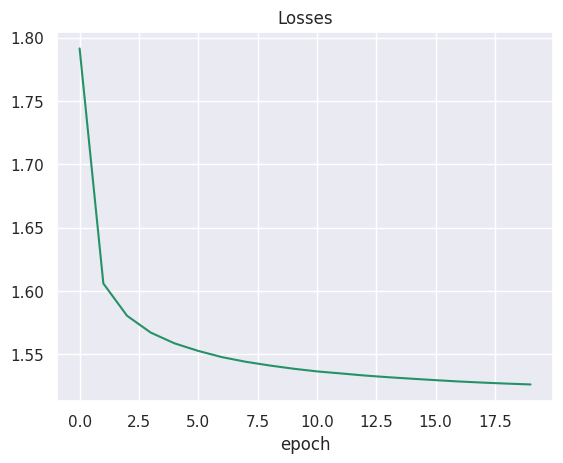

In [48]:
# лоси
losses = [1.7914391741056024,
  1.6060213096577083,
  1.5805288581067185,
  1.567237405322143,
  1.558777547939272,
  1.5528194322956537,
  1.5479106631088535,
  1.5442518907786502,
  1.541332561931057,
  1.538801109749493,
  1.5366555613234771,
  1.535068685439258,
  1.5334266556694236,
  1.532070808725463,
  1.5308875509928597,
  1.5297533940947146,
  1.5286724905386777,
  1.5278089319661696,
  1.5270269839580577,
  1.5263614414513558]
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

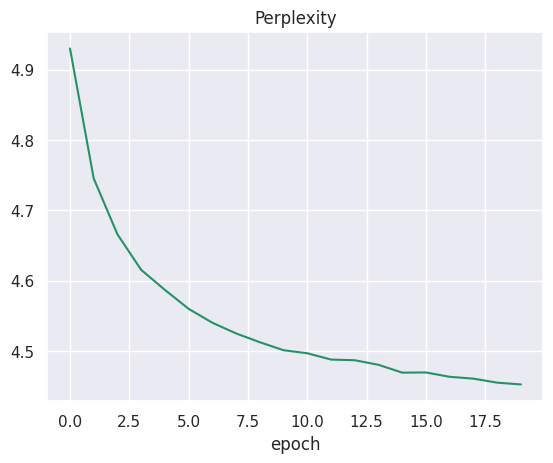

In [49]:
#спутанность-сложность
perplexities = [4.93018712204447,
  4.745198629964972,
  4.665785683409999,
  4.615253045209388,
  4.5867587443601465,
  4.559820983115989,
  4.5400708238196845,
  4.524845527263561,
  4.512345005351205,
  4.500959762946087,
  4.496662636902278,
  4.487699613355529,
  4.486735775034242,
  4.480244586799894,
  4.469089148081105,
  4.469348334640069,
  4.46316024598025,
  4.460544991545396,
  4.454857790235357,
  4.452295632713646]
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Чтобы "всё работало":

1. уменьшил размер батча до batch_size = 16 (на семинарском 128 был ООМ)
2. hidden dim сделал 64
3. выкосил в обучении tqdm - в чатике говорили, что из-за него каггл может фризиться

попробовал 2 модели: 
1. "как в семинаре" (gru)
2. добавил LayerNorm 
    
у первой evaluate на тестовом датасете - 4.700847187153533; Perplexity = 4.6989

у второй evaluate на тестовом датасете -    ; Perplexity = 4.4523

2-я по преплексити лучше, но насколько это значимо, посмотрю на инференсе (только придумаю, как :-)